In [4]:
 # Check that have our correct Kernel running
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/conda/envs/python/bin/python
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


# Predicting Solids in Rivers
## Background
Equations used to compute bed load transport in rivers and streams are based upon regression analysis of data collected for variables related to solids load calculations. 
However, these methods have been found to be difficult to use, too complex for practical use, and/or inadequate in terms of estimation precision. 
\ref developed and deployed a database-search engine used to find approximate solutions of solids load transport based on model-specific input data. 
The tool is available via a web interface in an attempt to simplify and streamline sediment transport estimation. 
The search processing was all server-side, operating on a single, central database.

Here we will explore the underlying database and replicate some parts of the original work.
### 

## Concept of Distance in N-Dimensional Space
The concept of distance is vital to the search engine. In the screening tool the search input values, S, Q, U, and D50 are compared to their commensurate values in the database, and a distance is computed from the search values to values in the database. The nearest values in N-dimensional distance are selected (actually by a sort) and then used for the estimation of unit solids discharge for the search values. The search engine has several different kinds of distances that the engineer may select.

### Minkowski Distance
The distance between the search values and a database record is computed using  (Tan et al., 2008).

\begin{equation}
L_p= (|x_{1,data} - x_{1,search}|^p + |x_{2,data} - x_{2,search}|^p + \dots + |x_{N,data} - x_{N,search}|^p)^{\frac{1}{p}}
\end{equation}


`p` represents a parameter that modifies the Minkowski distance based upon its magnitude. 
When p > 0 and integer produces a quantity known as the Minkowski distance. 
The Euclidean distance between the two vectors xdata and xsearch, which is the hypotenuse-type distance that engineers are readily familiar with, is the special case of Equation 9 when p = 2, and the distance itself is called the L2-norm. 
In many situations, the Euclidean distance is insufficient for capturing the actual distances in a given high-dimensional space if traverse of that space along a hypotenuse is infeasible. 
For example, taxi drivers in Manhattan should measure distance not in terms of the length of the straight line to their destination, but in terms of the Manhattan (taxi distance) distance, which takes into account that streets are either orthogonal or parallel to each other.
The taxi distance is also called the L1 norm and is the special case of Equation 9 when p=1. 
This distance measures the shortest path along Cartesian axes (like city streets).

When some elements are unknown (as may be the case in our searches) or the noise in the elements is substantial, the Euclidean distance is not the most appropriate measure of distance, hence the value of p is left as a variable (Erickson,2010).
## Data Value Standardization
The variables in the database are not expressed in the same magnitude, range, and scale. 
For example, discharge values are several orders of magnitude larger in the database than median grain diameter, hence the two are not directly comparable when computing a distance for the search algorithm. 
In such a case, one way to facilitate direct interpretation for comparing composite indices of the original data having different magnitudes and unit systems is to use normalization. 
Normalization serves the purpose of bringing the indicators into the same unit scale or unit base and makes distance computations appropriate.
Normalizing data is done using various standardization techniques to assign a value to each variable so that they may be directly compared without unintentional bias due to differences in unit scale.

### Z-score Standardization
Z-score standardization is a commonly used normalization method that converts all indicators to a common scale with an average of zero and standard deviation of one. This transformation is the same as computing a standard-normal score for each data value. 
The average of zero avoids the introduction of aggregation distortions stemming from differences in indicators’ means. 
The scaling factor is the standard deviation of the indicator across, for instance, the velocities, slopes or unit solids discharges being ranked. 
Thus, an indicator with extreme values will have intrinsically a greater effect on the composite indicator. 
The raw score on each data entry is converted to a Z-score, then distances are calculated using the Z-scores for each variable rather than the raw value. 
Upon completion of the distance calculations and selection of the nearest neighbors, the results are transformed back into the raw values for subsequent presentation. 
Equation 10 shows the basic z-score formula used to normalize data sets (TIBCO).
$z = \frac{(x − μ)}{σ}$
 33
Equation 10
 
### Unit-Interval [0,1] Standardization
An alternate approach considered for the screening algorithm is an option to use a mapping of each variable in the database to a [0,1] scale and linearly weight within the scale. 
This standardization has the same goal as Z-score, which is to prevent one variable from overwhelming the distance computations because of its relative magnitude. 
The unit interval [0,1] standardization technique differs from the Z-score in that the variability is governed by the minimum and maximum value for each variable, and hence extrapolation is not feasible. 
Because extrapolation is likely necessary until new records are added to the database, this standardization method is not appropriate.

### Unstandardized
The unstandardized approach is not apprpriate because discharge and/or velocity completely dominate any search algorithm, almost to the exclusion of the other variables. 
The option was useful for method testing and database error detection but is not useful for production application.

### Download Current Database
Download using http:get method to access the public database from the source URL.

In [1]:
import requests # Module to process http/https requests
remote_url="http://54.243.252.9/engr-1330-webroot/9-MyJupyterNotebooks/43-SolidsInRivers/solids_in_rivers.csv"  # set the url
rget = requests.get(remote_url, allow_redirects=True, verify=False)  # get the remote resource, follow imbedded links, ignore the certificate
open('solids_in_rivers.csv','wb').write(rget.content) # extract from the remote the contents, assign to a local file same name
import pandas as pd # Module to process dataframes (not absolutely needed but somewhat easier than using primatives, and gives graphing tools)

In [208]:
riverdb = pd.read_csv("solids_in_rivers.csv")
#riverdb.head()
#print(riverdb["D50_m"])
riverdb.describe()

ID        Q_m3_s        q_m2_s         U_m_s           W_m  \
count  12081.000000  12401.000000  12401.000000  11270.000000  12401.000000   
mean    1940.571724    195.722908      0.967272      0.891899     30.219469   
std     2949.308625   1294.763761      2.747765      0.545093     94.382748   
min        1.000000      0.000500      0.001094      0.047000      0.076200   
25%       37.000000      0.041300      0.071941      0.490000      0.710000   
50%      114.000000      0.699000      0.197778      0.760000      4.880000   
75%     3554.000000      8.080000      0.643761      1.152320     13.140000   
max     9825.000000  28822.300000    101.618000      4.100000   1109.420000   

                H_m          R_m         S_m_m        D16_m         D50_m  \
count  11704.000000  9675.000000  12289.000000  7359.000000  12401.000000   
mean       0.738820     0.606682      0.011017     0.019633      0.036385   
std        1.807773     1.543387      0.018917     0.021628      0.048645   
min        0.000000     0.007562      0.000002     0.000066      0.000011   
25%        0.124400     0.070938      0.001240     0.002000      0.000640   
50%        0.270000     0.153412      0.004000     0.014000      0.011700   
75%        0.590000     0.450000      0.013000     0.033000      0.063000   
max       77.000000    16.246300      0.200000     0.098000      0.220000   

       ...  Record_Number        Froude   GammaS_N_m3   GammaF_N_m3  \
count  ...   12401.000000  11269.000000  12401.000000  12401.000000   
mean   ...    6380.274897      0.536185  25629.979244   9805.728190   
std    ...    3696.599235      0.369873   2214.983569    128.285394   
min    ...       1.000000      0.026609  10100.800000   9745.510000   
25%    ...    3101.000000      0.319346  25987.600000   9794.920000   
50%    ...    6487.000000      0.446229  25987.600000   9803.980000   
75%    ...    9587.000000      0.637954  25987.600000   9803.980000   
max    ...   12687.000000      5.687350  41384.100000  13366.500000   

       Tau0_kg_m_s2      TauStar    Ustar_m_s     ManningN         WP_m  \
count   9563.000000  9563.000000  9563.000000  9270.000000  9382.000000   
mean      21.922912     0.210218     0.114883     0.039846    29.447613   
std       31.256190     0.375793     0.093251     0.042504   103.538520   
min        0.027512     0.005681     0.005246     0.001850     0.121153   
25%        1.310125     0.036348     0.036224     0.014014     0.800300   
50%        6.218710     0.067029     0.078964     0.021891     1.676300   
75%       33.615450     0.222178     0.183112     0.048671    13.457700   
max      207.570000     7.761280     0.455660     0.372269  1142.270000   

               A_m2  
count  11270.000000  
mean     158.835167  
std      992.809279  
min        0.001200  
25%        0.065400  
50%        0.763333  
75%        7.174412  
max    18225.400000  

[8 rows x 27 columns]

<AxesSubplot:xlabel='D16_m', ylabel='D50_m'>

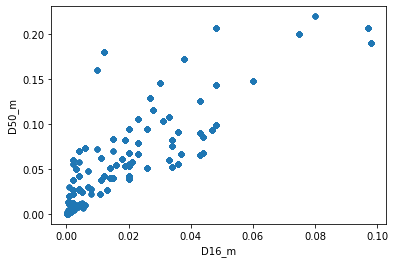

In [213]:
riverdb.plot.scatter(x='D16_m',y='D50_m')

<AxesSubplot:xlabel='R_m', ylabel='q_m2_s'>

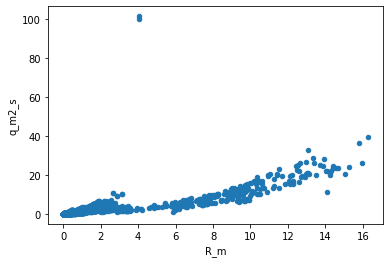

In [3]:
riverdb.plot.scatter(x='R_m',y='q_m2_s')

In [ ]:
## Now delete the local copy
! rm solids_in_rivers.csv

In [61]:
import math
def phi_value(diameter):
    # diameter in meters
    diameter = diameter*1000.0 # convert to millimeters
#    print(diameter)
    phi_value = 1.0*math.log2(diameter)
    return phi_value
def d_value(phi_val):
    # phi_val is log2(diam), return diam
    d_value = 2.0**phi_val
    return d_value

In [207]:
mu = phi_value(0.00032004)
sigma = math.sqrt(1.22)/math.sqrt(2.)
myguess = mu
print(myguess)
print(d_value(myguess))

from scipy.optimize import newton

def f(x):
    global mu,sigma
    quantile = 0.5
    argument = (x - mu)/(math.sqrt(2.0)*sigma)    
    normdist = (1.0 + math.erf(argument))/2.0
    return normdist - quantile

phi50 = newton(f, myguess)

def f(x):
    global mu,sigma
    quantile = 0.05
    argument = (x - mu)/(math.sqrt(2.0)*sigma)    
    normdist = (1.0 + math.erf(argument))/2.0
    return normdist - quantile

phi05 = newton(f, myguess)

def f(x):
    global mu,sigma
    quantile = 0.16
    argument = (x - mu)/(math.sqrt(2.0)*sigma)    
    normdist = (1.0 + math.erf(argument))/2.0
    return normdist - quantile

phi16 = newton(f, myguess)

def f(x):
    global mu,sigma
    quantile = 0.84
    argument = (x - mu)/(math.sqrt(2.0)*sigma)    
    normdist = (1.0 + math.erf(argument))/2.0
    return normdist - quantile

phi84 = newton(f, myguess)

def f(x):
    global mu,sigma
    quantile = 0.90
    argument = (x - mu)/(math.sqrt(2.0)*sigma)    
    normdist = (1.0 + math.erf(argument))/2.0
    return normdist - quantile

phi90 = newton(f, myguess)


print('d05 = ',d_value(phi05)/1000,'  millimeters')
print('d16 = ',d_value(phi16)/1000,'  millimeters')
print('d50 = ',d_value(phi50)/1000,'  millimeters')
print('d84 = ',d_value(phi84)/1000,'  millimeters')
print('d90 = ',d_value(phi90)/1000,'  millimeters')

-1.6436758641647295
0.32004
d05 =  0.00013136495766569197   millimeters
d16 =  0.00018680794242288665   millimeters
d50 =  0.00032004   millimeters
d84 =  0.0005482936125281758   millimeters
d90 =  0.000640489979928618   millimeters


In [ ]:
	D16_m	D50_m	D84_m	D90_m
7185	0.043	0.126	0.28	0.339

In [ ]:
import math

def normdensity(x,mu,sigma):
    weight = 1.0 /(sigma * math.sqrt(2.0*math.pi))
    argument = ((x - mu)**2)/(2.0*sigma**2)
    normdensity = weight*math.exp(-1.0*argument)
    return normdensity

def normdist(x,mu,sigma):
    argument = (x - mu)/(math.sqrt(2.0)*sigma)    
    normdist = (1.0 + math.erf(argument))/2.0
    return normdist

In [73]:
math.sqrt(2)

1.4142135623730951